# Descarga del dataset de entrenamiento

In [1]:
!pip install onedrivedownloader
from onedrivedownloader import download

PATH_FILE = 'https://universidadfv-my.sharepoint.com/:u:/g/personal/9105559_alumnos_ufv_es/ERSsAk6BH2ZFn1j6teUiYQQBdaJTNM-yBfQbyyhJpMW00Q?e=5NAjOR'
download(url = PATH_FILE, filename = '', unzip=True, force_download=True, clean=False)

100%|██████████| 43.6M/43.6M [00:04<00:00, 9.28MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 8298/8298 [00:00<00:00, 13416.85it/s]


''

Para evitar overfitting en el set de validación, incorporaremos todos los datos de esta carpeta en la de train y usaremos k-folds para nuestro cross-validation.

# Preparación de los datos

In [2]:
import shutil
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold

In [3]:
# Define source and destination paths
src_image_dir = '/content/valid/images'
src_label_dir = '/content/valid/labels'
dest_image_dir = '/content/train/images'
dest_label_dir = '/content/train/labels'

# Move image files
for filename in os.listdir(src_image_dir):
    src_path = os.path.join(src_image_dir, filename)
    dest_path = os.path.join(dest_image_dir, filename)
    shutil.move(src_path, dest_path)

# Move label files
for filename in os.listdir(src_label_dir):
    src_path = os.path.join(src_label_dir, filename)
    dest_path = os.path.join(dest_label_dir, filename)
    shutil.move(src_path, dest_path)

# Remove the 'valid' folder
shutil.rmtree('/content/valid')

print("Files moved and 'valid' folder deleted successfully!")

Files moved and 'valid' folder deleted successfully!


**Reformateamos las imágenes para que tengan el mismo tamaño 512 x 512**



In [4]:
target_size = (512, 512)

def resize_images(image_dir, target_size=(512, 512)):
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            resized_image = cv2.resize(image, target_size)  # Resize to 512x512
            cv2.imwrite(image_path, resized_image)

# Resize images in training set
train_image_dir = '/content/train/images'
resize_images(train_image_dir)
print(f"Images in '{train_image_dir}' resized to {target_size}")

# Resize images in testing set
test_image_dir = '/content/test/images'
resize_images(test_image_dir)
print(f"Images in '{test_image_dir}' resized to {target_size}")

print("Image resizing completed for both training and testing sets.")

Images in '/content/train/images' resized to (512, 512)
Images in '/content/test/images' resized to (512, 512)
Image resizing completed for both training and testing sets.


**Comprobamos el número de imágenes que tienen labels**

In [5]:
def count_files_with_text(directory):
    files_with_text = 0
    total_files = 0

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            total_files += 1
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as f:
                content = f.read()
                if content:
                    files_with_text += 1

    return total_files, files_with_text

# Process the train directory
train_directory = '/content/train/labels'
total_train_files, train_files_with_text = count_files_with_text(train_directory)
print(f"Total number of files in '{train_directory}': {total_train_files}")
print(f"Number of files with text in '{train_directory}': {train_files_with_text}")

# Process the test directory
test_directory = '/content/test/labels'
total_test_files, test_files_with_text = count_files_with_text(test_directory)
print(f"Total number of files in '{test_directory}': {total_test_files}")
print(f"Number of files with text in '{test_directory}': {test_files_with_text}")

Total number of files in '/content/train/labels': 3979
Number of files with text in '/content/train/labels': 1977
Total number of files in '/content/test/labels': 169
Number of files with text in '/content/test/labels': 83


**Eliminamos las imágenes que no tienen labels, es decir, aquellas cuyo archivo .txt estén vacíos**

In [6]:
def clean_empty_labels(label_dir, image_dir):
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_dir, filename)
            image_path = os.path.join(image_dir, filename[:-4] + '.jpg')  # Assuming images are .jpg

            with open(label_path, 'r') as f:
                content = f.read().strip()  # Read and remove leading/trailing whitespace

            if not content:  # If the .txt file is empty
                os.remove(label_path)

                if os.path.exists(image_path):  # If corresponding image exists
                    os.remove(image_path)

# Specify the directories
label_dir = '/content/train/labels'  # Directory containing .txt label files
image_dir = '/content/train/images'  # Directory containing corresponding image files

# Perform the cleaning
clean_empty_labels(label_dir, image_dir)

print("Cleaning completed.")

Cleaning completed.


In [7]:
def clean_empty_labels(label_dir, image_dir):
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_dir, filename)
            image_path = os.path.join(image_dir, filename[:-4] + '.jpg')  # Assuming images are .jpg

            with open(label_path, 'r') as f:
                content = f.read().strip()  # Read and remove leading/trailing whitespace

            if not content:  # If the .txt file is empty
                os.remove(label_path)

                if os.path.exists(image_path):  # If corresponding image exists
                    os.remove(image_path)

# Specify the directories
label_dir = '/content/test/labels'  # Directory containing .txt label files
image_dir = '/content/test/images'  # Directory containing corresponding image files

# Perform the cleaning
clean_empty_labels(label_dir, image_dir)

print("Cleaning completed.")

Cleaning completed.


In [8]:
import os

def update_labels(label_dir):
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_dir, filename)

            with open(label_path, 'r') as f:
                line = f.readline().strip()  # Read the first line

                # Check if the line is empty
                if not line:
                    print(f"Skipping empty file: {filename}")
                    continue

                first_number = line.split()[0]  # Get the first number (class ID)

            with open(label_path, 'w') as f:
                f.write(first_number)  # Write only the first number back to the file


# Specify the label directories
label_directories = ['/content/train/labels', '/content/test/labels']

# Update labels in each directory
for label_dir in label_directories:
    update_labels(label_dir)
    print(f"Labels in {label_dir} updated.")

print("Label updating completed for all directories.")

Labels in /content/train/labels updated.
Labels in /content/test/labels updated.
Label updating completed for all directories.


# Carga de las imágenes parta el entrenamiento

Categorías:
0. Fractura de Codo
1. Fractura de Dedos
2. Fractura de Antebrazo
4. Fractura de Húmero
5. Fractura de Hombro
6. Fractura de Muñeca


In [10]:
# Define paths to your data
train_image_dir = '/content/train/images'
train_label_dir = '/content/train/labels'
test_image_dir = '/content/test/images'
test_label_dir = '/content/test/labels'

# Function to load and preprocess images and labels
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, filename[:-4] + '.txt')  # Assuming labels are in .txt files

            img = cv2.imread(image_path)
            # No resizing here, keep original 512x512
            images.append(img)

            with open(label_path, 'r') as f:
                # Extract only the first number from the first line of the file
                first_line = f.readline().strip()
                label = int(first_line.split()[0])  # Split by whitespace and take the first element
                labels.append(label)

    unique_classes = np.unique(labels)
    return np.array(images), np.array(labels), unique_classes

# Load training and testing data
X_train, y_train, train_classes = load_data(train_image_dir, train_label_dir)
X_test, y_test, test_classes = load_data(test_image_dir, test_label_dir)

print("Unique classes in training data:", train_classes)
print("Unique classes in testing data:", test_classes)

Unique classes in training data: [0 1 2 4 5 6]
Unique classes in testing data: [0 1 2 4 5 6]


**DATA AUGMENTATION: Para mejorar el rendimiento del modelo**

In [11]:
# Definir el generador de aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Definición del modelo

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG19 preentrenado sin la capa superior (sin la capa de clasificación)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Congelar las capas base para que no se entrenen
base_model.trainable = False

# Añadir tus propias capas de clasificación
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # Número de clases
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# ... (código anterior para cargar y preprocesar datos, definir modelo VGG19) ...

# Entrenar el modelo VGG16 con 10 epochs
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Usando el generador de aumento de datos
    epochs=25,
    validation_data=(X_test, y_test)
)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión en el conjunto de prueba: {accuracy}")

# ... (código posterior para visualizar resultados o guardar el modelo) ...

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.1874 - loss: 2.0095 - val_accuracy: 0.5060 - val_loss: 1.4136
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4236 - loss: 1.5309 - val_accuracy: 0.6506 - val_loss: 1.1474
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5849 - loss: 1.2986 - val_accuracy: 0.6627 - val_loss: 0.9730
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6581 - loss: 1.1290 - val_accuracy: 0.7590 - val_loss: 0.8621
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6643 - loss: 1.0170 - val_accuracy: 0.7831 - val_loss: 0.7876
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7276 - loss: 0.9314 - val_accuracy: 0.7590 - val_loss: 0.7149
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7319 - loss: 0.8554 - val_accuracy: 0.7711 - val_loss: 0.6617
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7629 - loss: 0.7964 - val_accuracy: 0.7952 - val_loss: 0.

# Evaluación del modelo

In [14]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step - accuracy: 0.8550 - loss: 0.4088
Validation Accuracy: 0.8192771077156067


**Precisión**

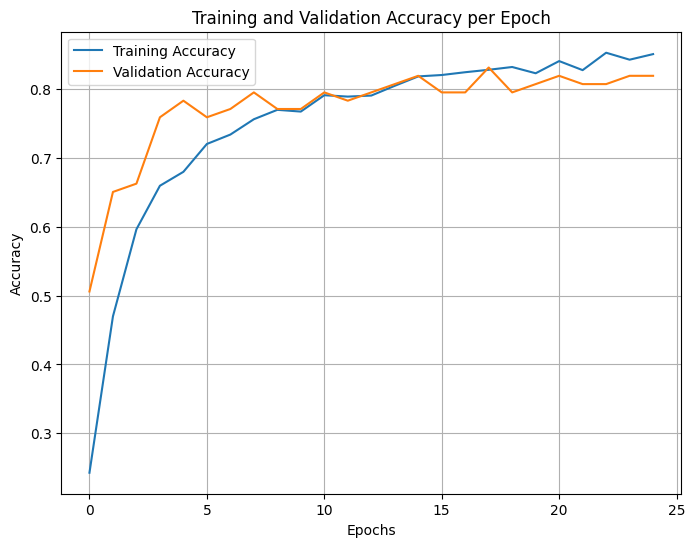

In [33]:
# Graficar la precisión de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Error**

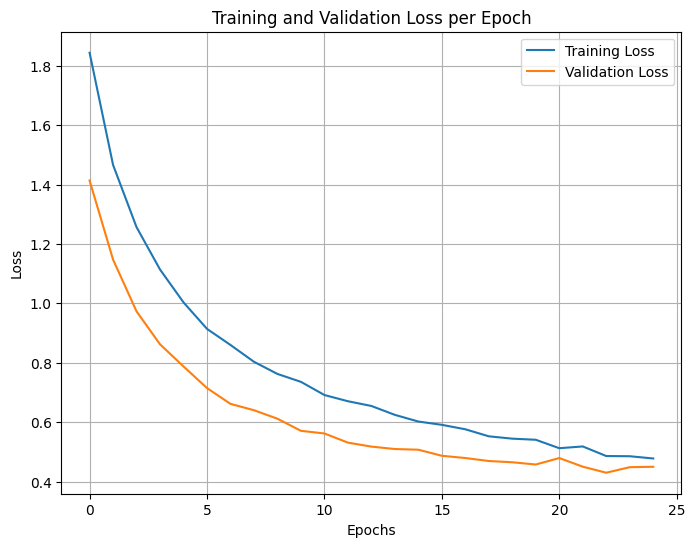

In [31]:
# Graficar el error de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Matriz de confusión**

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 805ms/step


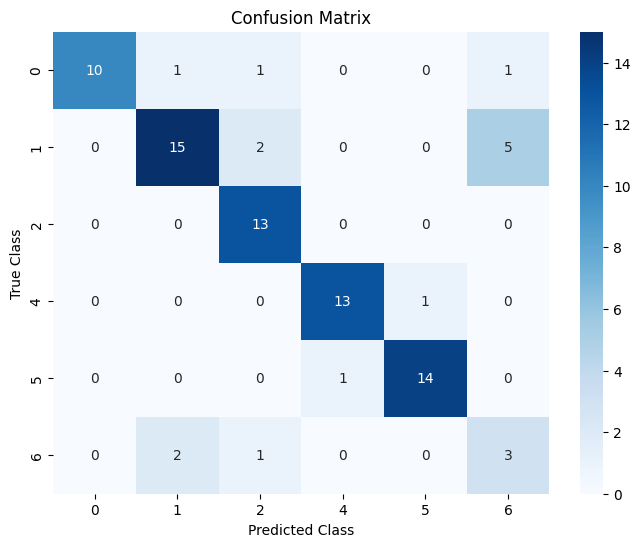

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Realiza las predicciones con el modelo
y_pred = model.predict(X_test)

# Convertir las probabilidades a clases predichas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión asegurando incluir todas las etiquetas
cm = confusion_matrix(y_test, y_pred_classes, labels=test_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.title('Matriz de confusión')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


**Curva ROC**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


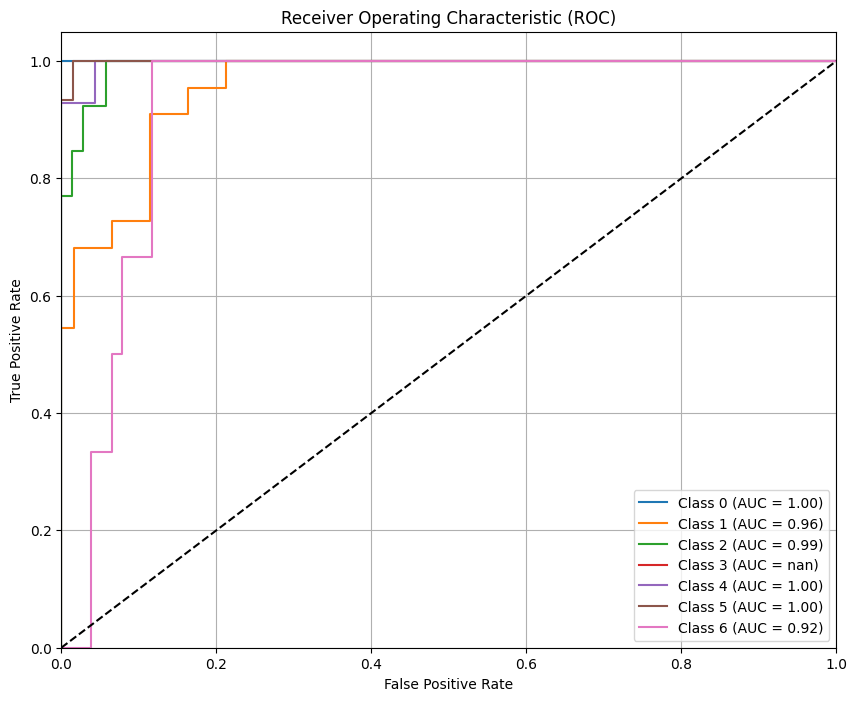

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.models import load_model

# Calcular y graficar la curva ROC y el AUC
# Si las etiquetas verdaderas no están en formato one-hot, las convertimos
if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    y_test_one_hot = np.eye(y_pred.shape[1])[y_test]
else:
    y_test_one_hot = y_test

# Crear una curva ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(y_pred.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Configuración de la gráfica
plt.plot([0, 1], [0, 1], 'k--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**F1 Score ponderado**, dónde las clases van de 0 a 5, aunque realmente son [0, 1, 2, 4, 5, 6]

In [22]:
from sklearn.metrics import f1_score

# Calcular el F1-score por clase
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

# Calcular el F1-score promedio ponderado
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

# Mostrar los resultados
print("F1-score por clase:")
for i, f1 in enumerate(f1_per_class):
    print(f"Clase {i}: {f1:.2f}")

print(f"\nF1-score promedio ponderado: {f1_weighted:.2f}")


F1-score por clase:
Clase 0: 0.87
Clase 1: 0.75
Clase 2: 0.87
Clase 3: 0.93
Clase 4: 0.93
Clase 5: 0.40

F1-score promedio ponderado: 0.82


**F1 Score macro**, dónde las clases van de 0 a 5, aunque realmente son [0, 1, 2, 4, 5, 6]

In [27]:
from sklearn.metrics import f1_score

# Calcular el F1-score por clase
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

# Calcular el F1-score promedio no ponderado (macro)
f1_macro = f1_score(y_test, y_pred_classes, average='macro')

# Mostrar los resultados
print("F1-score por clase:")
for i, f1 in enumerate(f1_per_class):
    print(f"Clase {i}: {f1:.2f}")

print(f"\nF1-score promedio no ponderado (macro): {f1_macro:.2f}")


F1-score por clase:
Clase 0: 0.87
Clase 1: 0.75
Clase 2: 0.87
Clase 3: 0.93
Clase 4: 0.93
Clase 5: 0.40

F1-score promedio no ponderado (macro): 0.79


**Imágenes con mayor probabilidad de pertenecer a cada clase**

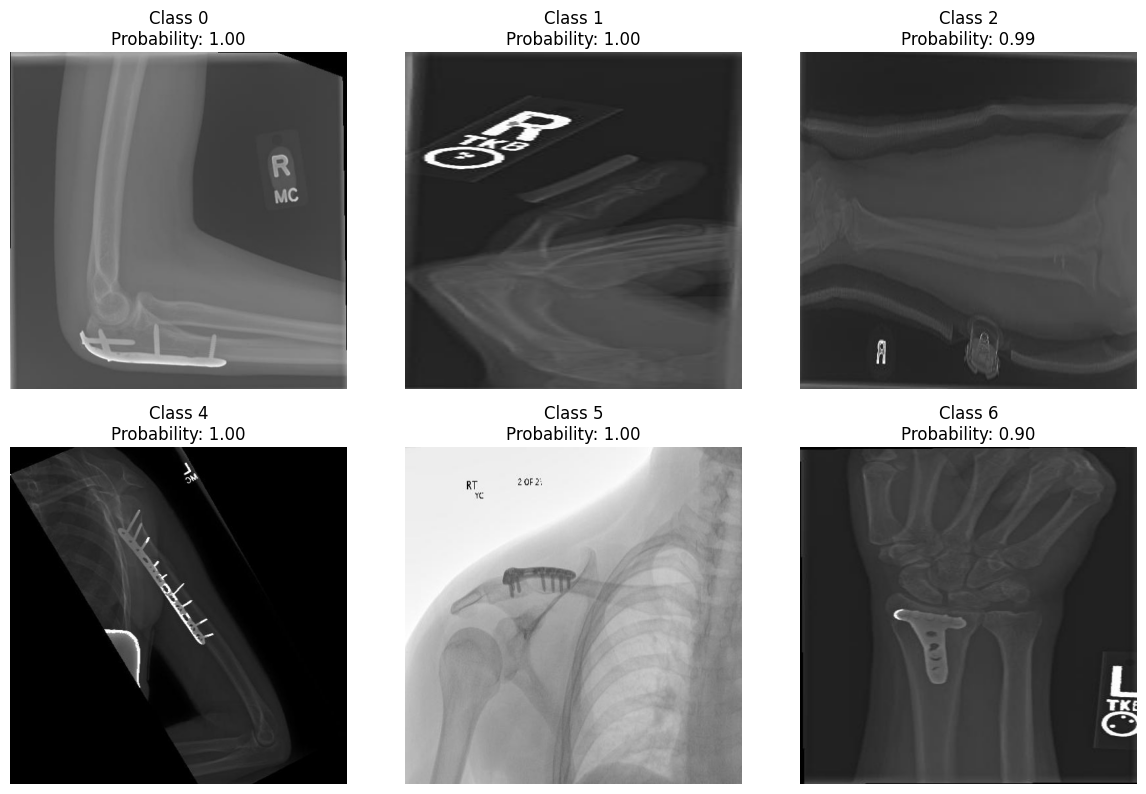

In [28]:
import matplotlib.pyplot as plt

# Crear un diccionario para almacenar la imagen y probabilidad máxima por clase
best_images = {class_label: {"image": None, "probability": 0} for class_label in classes}

# Iterar sobre las predicciones para encontrar la imagen con mayor probabilidad para cada clase
for i, probs in enumerate(y_pred):
    predicted_class = np.argmax(probs)  # Clase predicha
    max_prob = np.max(probs)  # Probabilidad máxima
    if max_prob > best_images[predicted_class]["probability"]:
        best_images[predicted_class]["probability"] = max_prob
        best_images[predicted_class]["image"] = X_test[i]

# Visualizar las imágenes con mayor probabilidad por clase
plt.figure(figsize=(12, 12))
for i, class_label in enumerate(classes):
    plt.subplot(3, 3, i + 1)  # Crear subgráfica
    image = best_images[class_label]["image"]
    prob = best_images[class_label]["probability"]
    if image is not None:
        plt.imshow(image)
        plt.title(f"Class {class_label}\nProbability: {prob:.2f}")
        plt.axis('off')
plt.tight_layout()
plt.show()
